<a href="https://colab.research.google.com/github/SurakshaRV/Chatbot-for-skin-disease-diagnosis/blob/main/Finetuned_skin_disease_classification_with_MobileNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the libraries
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# The paths for the training and validation images
train_path = '/content/drive/MyDrive/base_dir/train_dir'
valid_path = '/content/drive/MyDrive/base_dir/test_dir/val_dir'
test_path= '/content/drive/MyDrive/base_dir/test_dir/testing_dir'

#number of images in the training set
num_train_samples = 6009
#number of images in the evaluation set
num_val_samples = 2003
#number of images in the test set
num_test_samples = 2004
#dimensions of the image that will be inputed into the network (224x224)
image_size = 224

train_batch_size = 20
val_batch_size = 20

# Declare how many steps are needed in an iteration
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [4]:
# Set up generators
train_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, #pointing to the path where the data is stored
    target_size=(image_size, image_size), #the target size of the image output
    batch_size=train_batch_size) #size of the batches

valid_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size)

test_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False)

Found 25591 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.
Found 2004 images belonging to 7 classes.


In [5]:
#Create a MobileNet model
mobile = keras.applications.mobilenet.MobileNet()

# Modify the model
# Choose the 6th layer from the last
x = mobile.layers[-6].output

# Add a dropout and dense layer for predictions
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# Create a new model with the new outputs
model = Model(inputs=mobile.input, outputs=predictions)

# Prevent everything except the last 23 layers from being trained
for layer in model.layers[:-23]:
  layer.trainable = False

17227776/17225924 [==============================] - 0s 0us/step


In [6]:
# Define Top2 and Top3 Accuracy
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

# Add weights to make the model more sensitive to melanoma
class_weights={
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 1.0,  # mel
    5: 1.0,  # nv
    6: 1.0,  # vasc
}

In [7]:
filepath = "/content/drive/MyDrive/skin_lesion_model_bestacc.h5"

# Compile the model
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

# Declare a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Fit the model
history = model.fit_generator(train_batches,
                              steps_per_epoch=train_steps,
                              class_weight=class_weights,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=20,
                              verbose=1,
                              callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
301/301 [==============================] - ETA: 0s - loss: 1.2516 - categorical_accuracy: 0.5748 - top_2_accuracy: 0.7709 - top_3_accuracy: 0.8839 
Epoch 00001: val_top_3_accuracy improved from -inf to 0.91313, saving model to /content/drive/MyDrive/skin_lesion_model_bestacc.h5
301/301 [==============================] - 4567s 15s/step - loss: 1.2516 - categorical_accuracy: 0.5748 - top_2_accuracy: 0.7709 - top_3_accuracy: 0.8839 - val_loss: 2.2023 - val_categorical_accuracy: 0.6815 - val_top_2_accuracy: 0.8003 - val_top_3_accuracy: 0.9131
Epoch 2/20
301/301 [==============================] - ETA: 0s - loss: 0.8090 - categorical_accuracy: 0.7030 - top_2_accuracy: 0.8703 - top_3_accuracy: 0.9510
Epoch 00002: val_top_3_accuracy improved from 0.91313 to 0.91663, saving model to /content/drive/MyDrive/skin_lesion_model_bestacc.h5
301/301 [==============================] - 2863s 10s/step - loss: 0.8090 - c

In [ ]:
print(history.history['lr'])

[0.01, 0.01, 0.01, 0.01, 0.01, 0.005, 0.005, 0.005, 0.005, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.00125, 0.00125, 0.000625, 0.000625, 0.0003125]


In [8]:
# Evaluation of the best epoch
model.load_weights('/content/drive/MyDrive/skin_lesion_model_bestacc.h5')

test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc = model.evaluate_generator(test_batches, steps=val_steps)
# for epochs=20
print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
test_loss: 0.6358324289321899
test_cat_acc: 0.7849301099777222
test_top_2_acc: 0.9271457195281982
test_top_3_acc: 0.9770458936691284


In [9]:
# Create a confusion matrix of the test images
test_labels = test_batches.classes

# Make predictions
predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
101/101 [==============================] - 89s 876ms/step


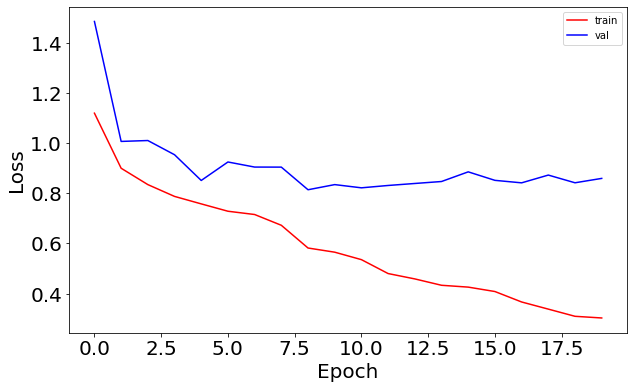

In [10]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

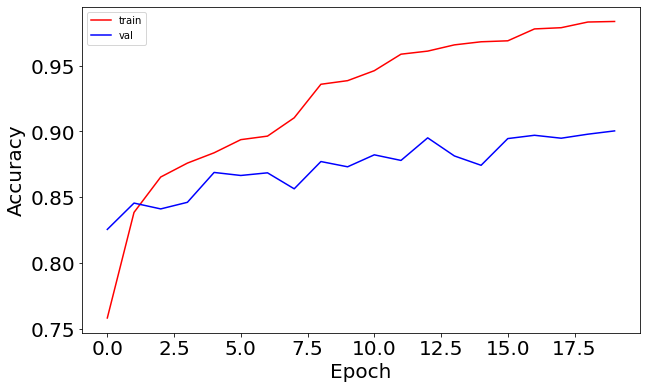

In [11]:
# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['categorical_accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_categorical_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [37]:
# Declare a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    TP=TN=FP=FN=0
    for i in range(7):
        TP+=cm[i][i]
    
    from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
    '''print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)'''
    
    # calculate accuracy
    #conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    Accuracy=accuracy_score(test_labels, predictions.argmax(axis=1))
    
    # calculate mis-classification
    #conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    #conf_sensitivity = (TP / float(TP + FN))
    RecallScore=recall_score(test_labels, predictions.argmax(axis=1), average=None)
    # calculate the specificity
    #conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    #conf_precision = (TN / float(TN + FP))
    Precision=precision_score(test_labels, predictions.argmax(axis=1), average=None)
    # calculate f_1 score
    #conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    F1=f1_score(test_labels, predictions.argmax(axis=1), average=None)
    print('-'*50)
    print(f'Accuracy: {Accuracy}') 
    #print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity/Recall Score: {RecallScore}') 
    print(f'Average Sensitivity/Recall Score: {sum(RecallScore)/7}')
    #print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {Precision}')
    print(f'Average Precision: {sum(Precision)/7}')
    print(f'f_1 Score: {F1}')
    print(f'Average f_1 Score: {sum(F1)/7}')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[  44    5   12    0    3    1    0]
 [   9   71   11    0    3    9    0]
 [  13    6  151    0   24   26    0]
 [   2    1    2   13    3    2    0]
 [   5    3   31    1  116   66    0]
 [   5   21   49    3  102 1161    1]
 [   0    4    0    0    3    5   17]]
--------------------------------------------------
Accuracy: 0.7849301397205589
Sensitivity/Recall Score: [0.67692308 0.68932039 0.68636364 0.56521739 0.52252252 0.86512668
 0.5862069 ]
Average Sensitivity/Recall Score: 0.6559543698024155
Precision: [0.56410256 0.63963964 0.58984375 0.76470588 0.45669291 0.91417323
 0.94444444]
Average Precision: 0.6962289174674103
f_1 Score: [0.61538462 0.6635514  0.63445378 0.65       0.48739496 0.88897397
 0.72340426]
Average f_1 Score: 0.6661661397682946


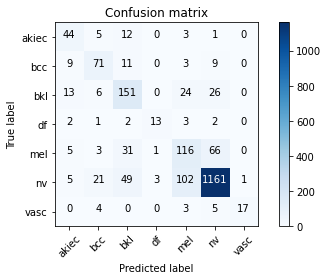

In [38]:
#plot the matrix
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# matrix labels
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels)

In [27]:
from sklearn import metrics
print(metrics.classification_report(test_labels,predictions.argmax(axis=1), target_names=cm_plot_labels))

              precision    recall  f1-score   support

       akiec       0.56      0.68      0.62        65
         bcc       0.64      0.69      0.66       103
         bkl       0.59      0.69      0.63       220
          df       0.76      0.57      0.65        23
         mel       0.46      0.52      0.49       222
          nv       0.91      0.87      0.89      1342
        vasc       0.94      0.59      0.72        29

    accuracy                           0.78      2004
   macro avg       0.70      0.66      0.67      2004
weighted avg       0.80      0.78      0.79      2004



In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import pandas as pd
# calculate roc curve

# structures
fpr = dict()
tpr = dict()
roc_auc = dict()
# calculate dummies once
y_test_dummies = pd.get_dummies(test_labels, drop_first=False).values
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:,i], predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

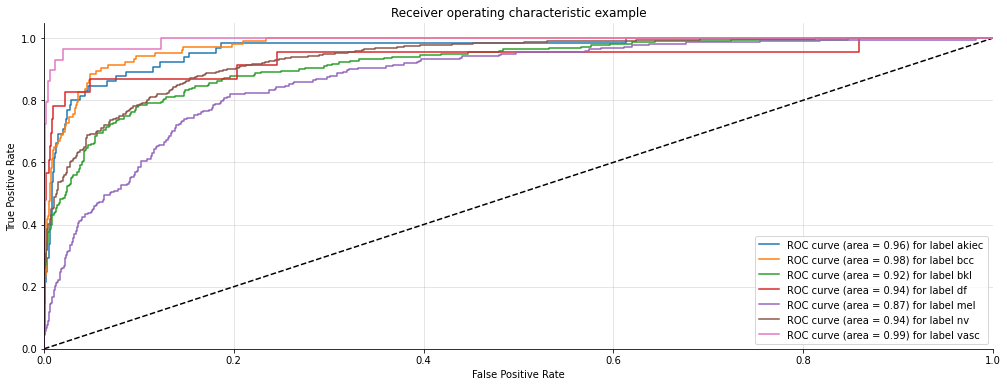

In [19]:
import seaborn as sns
# roc for each class
fig, ax = plt.subplots(figsize=(17,6))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
for i in range(7):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i],cm_plot_labels[i]))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()